## In this notebook, we'll use pyHalo to generate a realization of dark matter halos, then ray trace through them using lenstronomy (CPU) and JAXtronomy (GPU).

See the [JAX installation page](https://github.com/jax-ml/jax?tab=readme-ov-file#installation) to ensure that JAX is properly enabled for GPU support.

In [1]:
import jax

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "gpu")
assert jax.default_backend() == "gpu"
print(jax.devices())

from jax import explain_cache_misses

[CudaDevice(id=0)]


W1212 18:33:04.784598 1493278 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1212 18:33:04.788484 1493228 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


# Generate a realization of halos

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pyHalo.PresetModels.cdm import CDM
import time

realization contains 5190 halos.


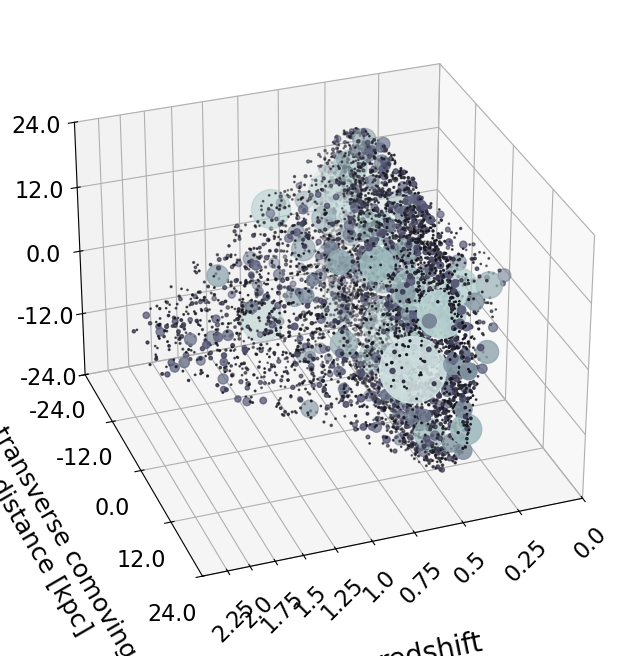

In [3]:
zlens, zsource = 0.5, 2.5
realizationCDM = CDM(zlens, zsource, cone_opening_angle_arcsec=5.5)
print("realization contains " + str(len(realizationCDM.halos)) + " halos.")

fig = plt.figure(2)
fig.set_size_inches(8, 8)
ax = plt.subplot(111, projection="3d")
realizationCDM.plot(ax)

# Create a lenstronomy LensModel class

pyHalo is designed to be used with lenstronomy. Extract the lensing quantities:

In [4]:
lens_model_list, lens_redshift_array, kwargs_halos, _ = (
    realizationCDM.lensing_quantities()
)

from collections import Counter

Counter(lens_model_list)

Counter({'TNFW': 5190, 'CONVERGENCE': 126})

In [5]:
from lenstronomy.LensModel.lens_model import LensModel as LensModel_lenstronomy

# You should use the same astropy class created in pyhalo to do lensing computations. The current default cosmology is Planck 2019
astropy_instance = realizationCDM.astropy_instance
lens_model_halos_only = LensModel_lenstronomy(
    lens_model_list=lens_model_list,
    z_source=zsource,
    lens_redshift_list=lens_redshift_array,
    cosmo=astropy_instance,
    multi_plane=True,
)

# Create a JAXtronomy LensModelGPU class
The API is inevitably different from lenstronomy due to incompatibilities with JAX. Instead of initializing the class with the full lens model list, we initialize it with a list of unique lens models. Additionally, the lens redshift list is not passed at initialization.

In [6]:
from jaxtronomy.LensModel.lens_model_gpu import LensModelGPU

unique_lens_model_list = list(set(lens_model_list))
print("Unique lens model list:", unique_lens_model_list)

lens_model_halos_only_jax = LensModelGPU(
    unique_lens_model_list,
    cosmo=astropy_instance,
    multi_plane=True,
)

Unique lens model list: ['TNFW', 'CONVERGENCE']


The full lens model list and lens redshift list are instead passed into the following helper function along with kwargs_lens and z_source. This function accomplishes two goals:
1) converts the keyword arguments from the typical lenstronomy convention to one that is compatible with JAX
2) performs all of the necessary cosmology calculations that will be needed for ray tracing ahead of time, since cosmology calculations have not been implemented in JAX

One shortcoming of JAX is that functions must recompile every time arrays change shape. If one wishes to ray trace through many different realizations of dark matter substructure, having a different number of deflectors leads to unnecessary recompilation of functions. To avoid this, we keep the number of deflectors fixed (in the following example to 5500), which is done under the hood by filling the lens model list with NULL deflectors.

In [7]:
ray_shooting_kwargs = lens_model_halos_only_jax.prepare_ray_shooting_kwargs(
    lens_model_list=lens_model_list,
    kwargs_lens=kwargs_halos,
    z_source=zsource,
    lens_redshift_list=lens_redshift_array,
    num_deflectors=5500,
)

Side note: The standard LensModel class in JAXtronomy (which has identical API to lenstronomy) will not work in this situation:

In [8]:
from jaxtronomy.LensModel.lens_model import LensModel

lens_model_jax = LensModel(
    lens_model_list=lens_model_list,
    z_source=zsource,
    lens_redshift_list=lens_redshift_array,
    cosmo=astropy_instance,
    multi_plane=True,
)

ValueError: Compile times grow exponentially with number of lenses. JAXtronomy's LensModel class may become unusable when number of lenses exceeds 300.
Instead, consider using the LensModelGPU class from jaxtronomy.LensModel.lens_model_gpu, which sidesteps this issue at the cost of having a different API.

# Benchmarking

Set up a 400 x 400 grid:

In [9]:
num_pix = 400

x = np.tile(np.linspace(-10, 10, num_pix), num_pix)
y = np.repeat(np.linspace(-10, 10, num_pix), num_pix)

In [10]:
start_time = time.perf_counter()
f_x, f_y = lens_model_halos_only.ray_shooting(x, y, kwargs_halos)
end_time = time.perf_counter()
lenstronomy_time = end_time - start_time
print(f"{lenstronomy_time} seconds taken for lenstronomy to ray trace on CPU")

46.09431323898025 seconds taken for lenstronomy to ray trace on CPU


The first time we perform ray shooting in JAX, the function needs to compile:

In [11]:
with explain_cache_misses():
    f_x_jax, f_y_jax = lens_model_halos_only_jax.ray_shooting(x, y, ray_shooting_kwargs)
    f_x_jax.block_until_ready()
    f_y_jax.block_until_ready()

  never seen function:
    alpha2rho0 id=140728094220960 defined at /gpfs/home/alhhuang/GitHub/JAXtronomy/jaxtronomy/LensModel/Profiles/nfw.py:389
  never seen function:
    alpha2rho0 id=140728094393504 defined at /gpfs/home/alhhuang/GitHub/JAXtronomy/jaxtronomy/LensModel/Profiles/tnfw.py:400
  never seen function:
    F id=140728094227040 defined at /gpfs/home/alhhuang/GitHub/JAXtronomy/jaxtronomy/LensModel/Profiles/tnfw.py:294
  never seen function:
    _L id=140728094226560 defined at /gpfs/home/alhhuang/GitHub/JAXtronomy/jaxtronomy/LensModel/Profiles/tnfw.py:282
  never seen function:
    _g id=140728094228000 defined at /gpfs/home/alhhuang/GitHub/JAXtronomy/jaxtronomy/LensModel/Profiles/tnfw.py:335
  never seen function:
    tnfw_alpha id=140728094225600 defined at /gpfs/home/alhhuang/GitHub/JAXtronomy/jaxtronomy/LensModel/Profiles/tnfw.py:232
  never seen function:
    derivatives id=140728094222080 defined at /gpfs/home/alhhuang/GitHub/JAXtronomy/jaxtronomy/LensModel/Profiles/t

Side note: To see what block_until_ready() is for, read about [Asynchronous Dispatch](https://docs.jax.dev/en/latest/async_dispatch.html) in JAX.

Now we have a fast ray shooting function:

In [12]:
num_iterations = 1

start_time = time.perf_counter()

for _ in range(num_iterations):
    f_x_jax, f_y_jax = lens_model_halos_only_jax.ray_shooting(x, y, ray_shooting_kwargs)
    f_x_jax.block_until_ready()
    f_y_jax.block_until_ready()

end_time = time.perf_counter()
jaxtronomy_gpu_time = (end_time - start_time) / num_iterations
print(
    f"{jaxtronomy_gpu_time} seconds taken for jaxtronomy ray tracing on GPU\n"
    f"{int(lenstronomy_time/jaxtronomy_gpu_time)}x faster than lenstronomy"
)

0.43621311092283577 seconds taken for jaxtronomy ray tracing on GPU
105x faster than lenstronomy


Sanity check to make sure we get the same answer:

In [13]:
np.testing.assert_allclose(f_x, f_x_jax, atol=1e-14, rtol=1e-14)
np.testing.assert_allclose(f_y, f_y_jax, atol=1e-14, rtol=1e-14)

Now let's compare this to jaxtronomy on CPU:

In [ ]:
cpu_ray_shooting_func = jax.jit(lens_model_halos_only_jax.ray_shooting, backend="cpu")

# COMPILE ON CPU
f_x_jax, f_y_jax = cpu_ray_shooting_func(x, y, ray_shooting_kwargs)
f_x_jax.block_until_ready()
f_y_jax.block_until_ready()

Array([-10.58157448, -10.5815351 , -10.58149553, ...,  10.58063778,
        10.58068342,  10.58072884], dtype=float64)

In [15]:
start_time = time.perf_counter()

for _ in range(num_iterations):
    f_x_jax, f_y_jax = cpu_ray_shooting_func(x, y, ray_shooting_kwargs)
    f_x_jax.block_until_ready()
    f_y_jax.block_until_ready()

end_time = time.perf_counter()
jaxtronomy_cpu_time = (end_time - start_time) / num_iterations
print(
    f"{jaxtronomy_cpu_time} seconds taken for jaxtronomy ray tracing on CPU\n"
    f"GPU is {int(jaxtronomy_cpu_time/jaxtronomy_gpu_time)}x faster"
)

7.800288308993913 seconds taken for jaxtronomy ray tracing on CPU
GPU is 17x faster


Let's try another substructure realization:

In [16]:
realizationCDM = CDM(zlens, zsource, cone_opening_angle_arcsec=5.5)
print("realization contains " + str(len(realizationCDM.halos)) + " halos.")

lens_model_list, lens_redshift_array, kwargs_halos, _ = (
    realizationCDM.lensing_quantities()
)
Counter(lens_model_list)

realization contains 5182 halos.


Counter({'TNFW': 5182, 'CONVERGENCE': 126})

As mentioned earlier, by keeping the number of deflectors fixed to 5500, JAX does not need to recompile.

In [17]:
ray_shooting_kwargs = lens_model_halos_only_jax.prepare_ray_shooting_kwargs(
    lens_model_list=lens_model_list,
    kwargs_lens=kwargs_halos,
    z_source=zsource,
    lens_redshift_list=lens_redshift_array,
    num_deflectors=5500,
)

with explain_cache_misses():
    f_x_jax, f_y_jax = lens_model_halos_only_jax.ray_shooting(x, y, ray_shooting_kwargs)
    f_x_jax.block_until_ready()
    f_y_jax.block_until_ready()